In [41]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh
from spyrit.misc.matrix_tools import *
from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *
from spyrit.misc.walsh_hadamard import walsh_matrix
from spyrit.core.Acquisition import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
N0 = 10     # Image intensity (in photons)

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size
# Cov /= img_size*img_size # THIS NEEDS TO BE NORMALIAZED FOR CONSISTENCY!

Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Pmat = np.dot(Perm,H);
Pmat = Pmat[:M,:];

In [36]:
# fadoua pour la doc uniquement
img_size = 64*64
M = 1024
batch_size = 10
Hcomplete = walsh_matrix(img_size)
Hsub = Hcomplete[:M,:]
Perm = np.array(np.random.random([img_size,img_size]))
FO_Shift = Forward_operator_shift(Hsub, Perm)
x = torch.tensor(np.random.random([batch_size,img_size]), dtype=torch.float)
y = FO_Shift(x) # y: belongs to Hadamard domain, which is square matrix
# as Hsub is not square, a completion by padding is proposed to implement the inverse recosntruction
y_pad = F.pad(y, (img_size-(M+1),0), "constant", 0)
FO_Shift_Had = Forward_operator_shift_had(Hsub, Perm)
x_reconstruct = FO_Shift_Had.inverse(y_pad) 
print(x.shape)
print(x_reconstruct.shape)

torch.Size([10, 4096])
torch.Size([10, 4096])


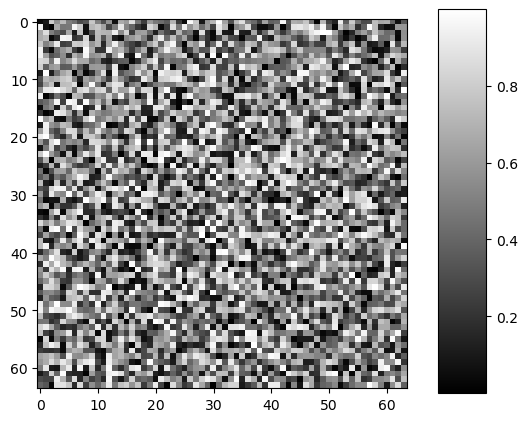

In [7]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Forward Operator
## Instancier

In [8]:
FO = Forward_operator(Pmat)

In [9]:
print(FO.N)
print(FO.M)
print(FO.Hsub)
print(FO.Hsub_adjoint)

4096
1024
Linear(in_features=4096, out_features=1024, bias=False)
Linear(in_features=1024, out_features=4096, bias=False)


In [10]:
print(FO.Hsub.weight.data)

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1., -1.,  ..., -1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])


In [11]:
print(FO.Hsub_adjoint.weight.data)

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [ 1., -1.,  1.,  ..., -1., -1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.]])


Pour fadoua - check that same weigths as Pmat and Pmat.T
And compare two lines

# forward method

In [12]:
y = FO(x)

In [13]:
y.shape

torch.Size([10, 1024])

Needs to be of shape (b*c, M)

## adjoint method

In [14]:
x_est = FO.adjoint(y)

In [15]:
x_est.shape

torch.Size([10, 4096])

Needs to be of shape (b*c, N)

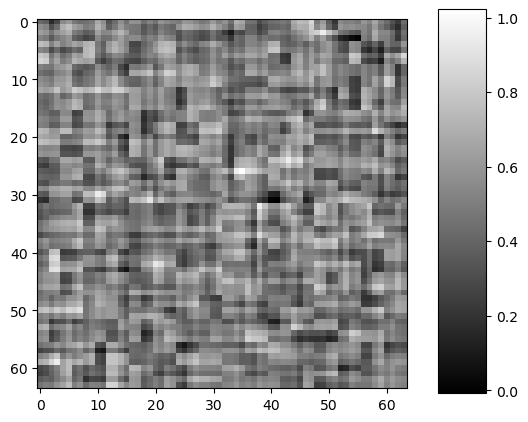

In [16]:
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

Close to initial image with downsample artifacts - OK

## Mat method

In [17]:
print(FO.Mat())
print(FO.Mat().shape)

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1., -1.,  ..., -1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
torch.Size([1024, 4096])


# Pos-neg split forward operator
## Instancier

In [18]:
FO_split = Split_Forward_operator(Pmat)

In [19]:
print(FO_split.N)
print(FO_split.M)
print(FO_split.Hsub)
print(FO_split.Hsub_adjoint)
print(FO_split.Hpos_neg)

4096
1024
Linear(in_features=4096, out_features=1024, bias=False)
Linear(in_features=1024, out_features=4096, bias=False)
Linear(in_features=4096, out_features=2048, bias=False)


In [20]:
print(FO_split.Hpos_neg.weight.data)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Display a few lines as images

In [21]:
m = FO_split((x+1)/2)

In [22]:
m.shape

torch.Size([10, 2048])

Should be of shape (bc, 2M)

In [23]:
even_index = range(0,2*M,2);
odd_index = range(1,2*M,2);
mplus = m[:, even_index];
mminus = m[:, odd_index];
y_est = 2*(mplus-mminus) - FO(torch.ones_like(x))
print((y-y_est)/torch.norm(y))

tensor([[ 1.8106e-08,  5.3751e-09,  1.4640e-08,  ..., -1.8530e-08,
         -3.8474e-08,  6.8038e-08],
        [ 0.0000e+00, -4.6679e-09, -1.5277e-08,  ..., -1.8671e-08,
         -4.9083e-08, -2.4612e-08],
        [ 0.0000e+00,  7.5676e-09,  1.6125e-08,  ...,  1.4145e-08,
         -4.5193e-08,  5.6580e-10],
        ...,
        [ 0.0000e+00, -2.7300e-08,  1.9237e-08,  ...,  3.3382e-08,
         -8.4870e-10,  7.6737e-08],
        [-7.2423e-08, -4.2011e-08,  2.8290e-10,  ...,  7.7798e-09,
          9.0528e-09,  3.2534e-08],
        [ 7.2423e-08, -7.6383e-09, -1.6691e-08,  ...,  1.3579e-08,
         -1.4428e-08,  1.3862e-08]])


Relative error in the $10^{-8}$s

# Split_Forward_operator_pylops 
## Instancier

In [24]:
# FO_Pyl = Split_Forward_operator_pylops(Pmat)

Tests will happen with tikhonov regularisation

# Split_Forward_operator_ft_had
## Instancier

In [25]:
FO_Had = Split_Forward_operator_ft_had(Pmat, Perm, h, w)

In [26]:
Perm@Perm.T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
print(FO_Had.Perm)
print(FO_Had.Perm.weight.data)

Linear(in_features=4096, out_features=4096, bias=False)
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [28]:
x_inv_tran = torch.zeros_like(x)
x_inv_tran[:,:M] = y
x_inv = FO_Had.inverse(x_inv_tran);

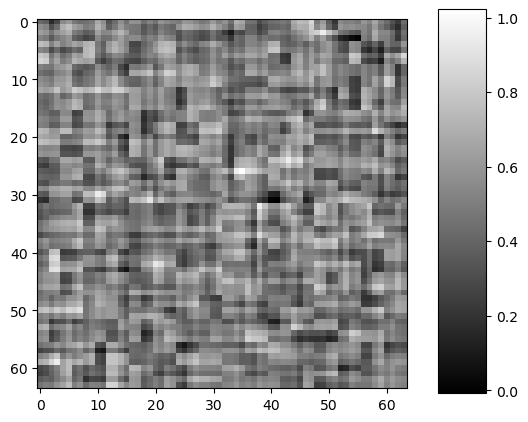

In [29]:
img = x_inv[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [30]:
# B = Bruit_Poisson_approx_Gauss(N0,F)

In [31]:
# m_alpha = B(x)

In [32]:
# m_alpha.shape

In [33]:
# print(N0*m-m_alpha)

In [34]:
# m

In [35]:
# m_alpha

Ok, seems like Bruit_Poisson_approx_Gauss works as intended